# Traffic Sign Recognition Classifier
**Objective:**
To build a traffic sign classifier with LeNet-5 CNN architecture using Tensorflow. The model was trained and evaluated on the German Traffic Sign Recognition Benchmark (GTSRB) dataset.

In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Create Image Data Pipepline
Loading GTSRB dataset from pickle files created by Udacity

In [2]:
# LOAD PICKLED DATA
import pickle

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

A basic summary of this dataset:

--- DATASET SUMMARY ---
Number of examples:
 + train: 34799
 + valid: 4410
 + test:  12630
Image shape: [32, 32]
Number of classes: 43

--- VISUALIZATION ---


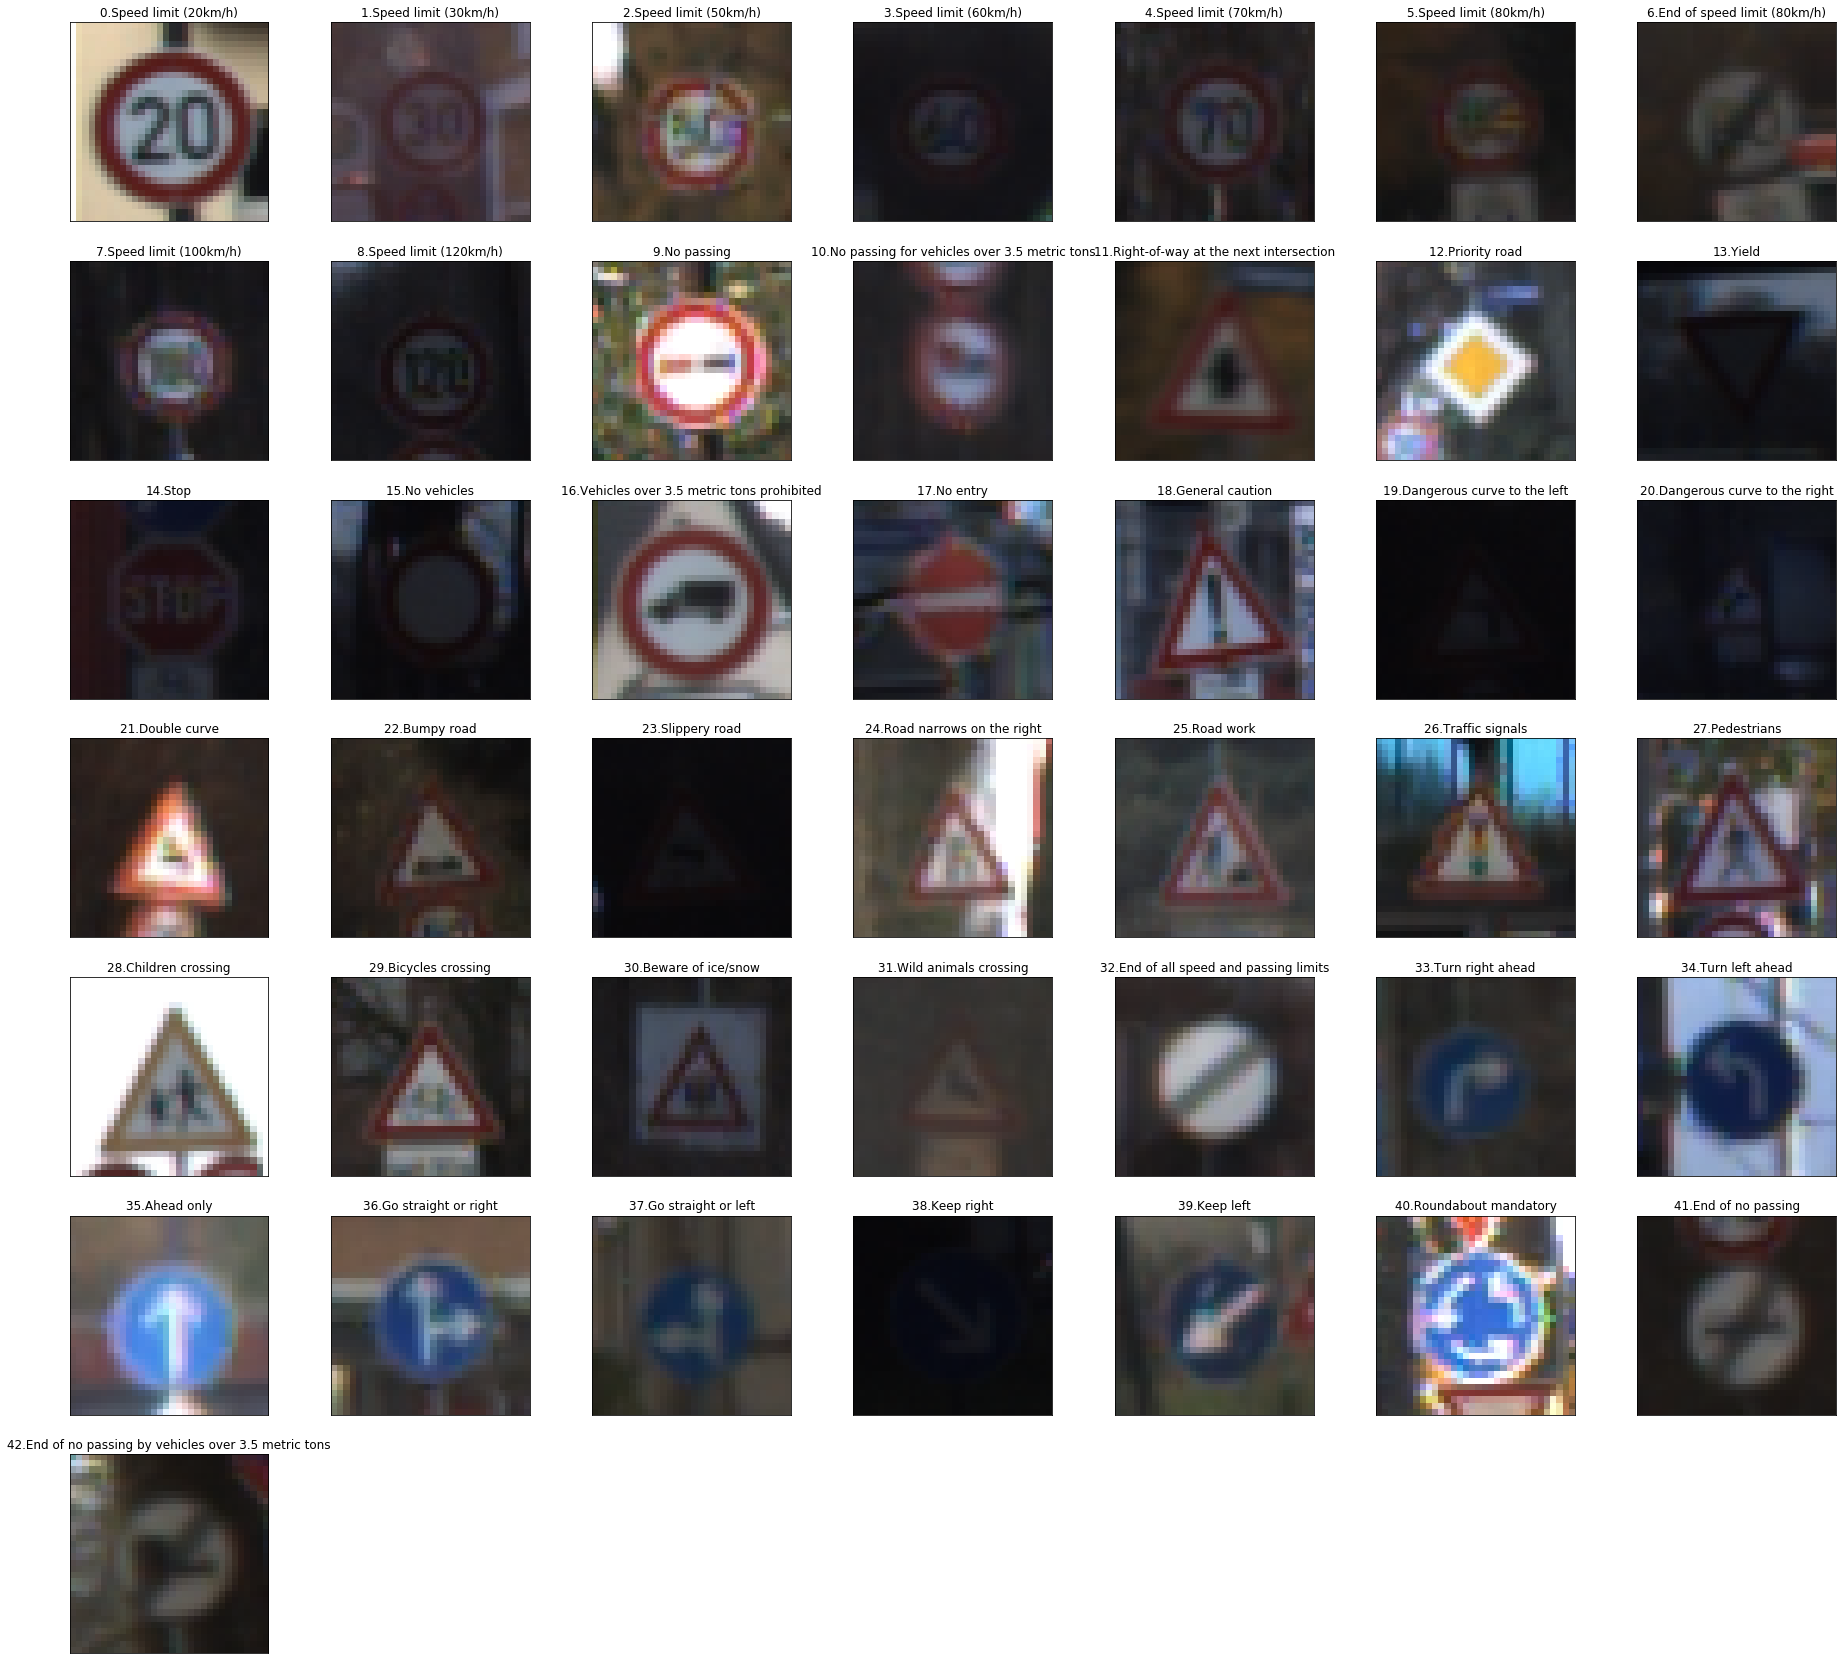


--- TRAIN_SET CLASS DISTRIBUTION ---


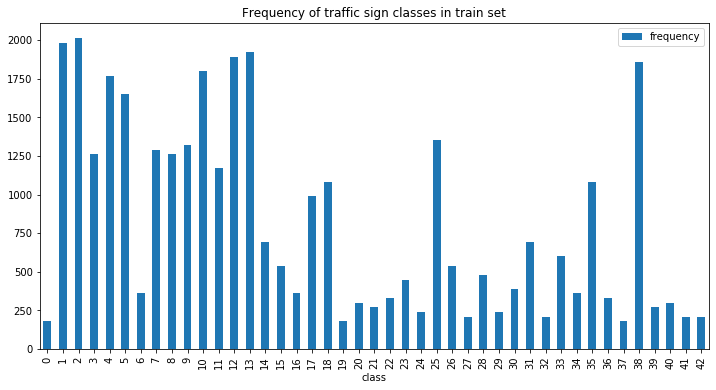

In [33]:
# Get image shape
image_shape = [X_test.shape[1], X_test.shape[2]]

# Get number of classes and frequency of each class in train set
classes_idx, frequency = np.unique(y_train, return_counts=True)
train_df = pd.DataFrame({'class':classes_idx, 'frequency':frequency}).set_index('class')
num_classes = len(classes)

# Load class names
import pandas as pd
classes = pd.read_csv('signnames.csv')
classes = classes['SignName'].to_numpy()

# Summary of GTSRB dataset
print("--- DATASET SUMMARY ---")
print(f"""Number of examples:
 + train: {len(X_train)}
 + valid: {len(X_valid)}
 + test:  {len(X_test)}
Image shape: {image_shape}
Number of classes: {len(classes)}""")

# Find and display an example for each class in train set
print("\n--- VISUALIZATION ---")
fig = plt.figure(figsize=(32, 30))
for idx in range(num_classes):
    image_idx = np.where(y_train == idx)[0][0]
    ax = fig.add_subplot(num_classes//7+1, 7, idx+1, xticks=[], yticks=[])
    ax.title.set_text(f'{idx}.{classes[idx]}')
    plt.imshow(X_train[image_idx])
plt.show()

# Plot class distribution of train set
print("\n--- TRAIN_SET CLASS DISTRIBUTION ---")
train_df.plot.bar(figsize=(12,6), title='Frequency of traffic sign classes in train set')

**Define all parameters here:**



In [17]:
# Training parameters
LEARNING_RATE = 0.001
EPOCHS = 25
BATCH_SIZE = 32

**Create a data loader using tf.data**:

In [5]:
def preprocess(images, labels=None):
    # Convert RGB image to Grayscale, then normalize image to range [-1, 1]
    processed_images = tf.image.rgb_to_grayscale(tf.dtypes.cast(images, tf.float32))
    processed_images = tf.image.per_image_standardization(processed_images)      
    if labels is None:
        return processed_images
    else:
        return processed_images, tf.dtypes.cast(labels, tf.int32)    

In [6]:
def dataloader(X, y):
    return tf.data.Dataset.from_tensor_slices((X, y)) \
                          .shuffle(len(X))          \
                          .map(preprocess)          \
                          .batch(BATCH_SIZE)        \
                          .prefetch(1)

## Step 2: Define CNN model architecture (LeNet-5)

In [18]:
# Define weights and biases
truncated_normal = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1)

weights = {
    # Conv Layer 1: 5x5 conv, 1 channel, 6 filters (Input is a grayscaled image)
    'conv1_w': tf.Variable(truncated_normal([5, 5, 1, 6])),
    # Conv Layer 2: 5x5 conv, 6 channels, 16 filters.
    'conv2_w': tf.Variable(truncated_normal([5, 5, 6, 16])),
    # FC Layer 1: 5*5*16 inputs, 120 units.
    'fc1_w'  : tf.Variable(truncated_normal([400, 120])),
    # FC Layer 2: 120 inputs, 84 units (total number of classes)
    'fc2_w'  : tf.Variable(truncated_normal([120, 84])),
    # FC Layer 3 (output): 84 inputs, 43 units (total number of classes)
    'fc3_w'  : tf.Variable(truncated_normal([84, num_classes]))
}

biases = {
    'conv1_b': tf.Variable(tf.zeros([6])),
    'conv2_b': tf.Variable(tf.zeros([16])),
    'fc1_b'  : tf.Variable(tf.zeros([120])),
    'fc2_b'  : tf.Variable(tf.zeros([84])),
    'fc3_b'  : tf.Variable(tf.zeros([num_classes]))
}

In [7]:
# Reload previous weights and biases
# fname = "trained_params.p"
# with open(fname, mode='rb') as f:
#     weights, biases = pickle.load(f)

In [19]:
# Define CNN model
def LeNet5(x):        
    # Layer 1: Convolutional + MaxPool. Input = 32x32x1. Output = 14x14x6
    conv1   = tf.nn.conv2d(x, weights['conv1_w'], strides=[1,1,1,1], padding='VALID') + biases['conv1_b']
    conv1   = tf.nn.relu(conv1)    
    conv1   = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') 
    
    # Layer 2: Convolutional + MaxPool. Input = 14x14x6. Output = 5x5x16
    conv2   = tf.nn.conv2d(conv1, weights['conv2_w'], strides=[1,1,1,1], padding='VALID') + biases['conv2_b']
    conv2   = tf.nn.relu(conv2)
    conv2   = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten: Input = 5x5x16. Output = 400.    
    fc0     = tf.reshape(conv2, [-1, weights['fc1_w'].get_shape().as_list()[0]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1     = tf.matmul(fc0, weights['fc1_w']) + biases['fc1_b']
    fc1     = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2     = tf.matmul(fc1, weights['fc2_w']) + biases['fc2_b']
    fc2     = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits  = tf.matmul(fc2, weights['fc3_w']) + biases['fc3_b']   
    return logits

In [20]:
def cross_entropy(y, logits):
    # Compute cross_entropy loss
    one_hot_y = tf.one_hot(y, depth=num_classes)
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    return tf.reduce_mean(xentropy)

def evaluate(X, y):
    # Compute prediction accuracy
    accuracy = tf.keras.metrics.Accuracy() 
    accuracy.reset_states()
    dataset  = dataloader(X, y)  
    for batch_x, batch_y in dataset:
        logits = LeNet5(batch_x)
        preds = tf.argmax(logits, 1)
        accuracy.update_state(preds, batch_y)
    return accuracy.result().numpy()

train_dataloader = dataloader(X_train, y_train)
m = tf.keras.metrics.Accuracy() 
optimizer = tf.optimizers.Adam(LEARNING_RATE)
trainable_variables = list(weights.values()) + list(biases.values())

## Step 3: Train, Validate, and Test the Model

In [21]:
# Train model
for i in range(EPOCHS):
    for batch_x, batch_y in train_dataloader:
        with tf.GradientTape() as g:
            logits = LeNet5(batch_x)
            loss = cross_entropy(batch_y, logits)
        preds = tf.argmax(logits, 1)
        trainable_variables = list(weights.values()) + list(biases.values())
        m.update_state(preds, batch_y) 
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    train_accuracy = m.result().numpy()
    valid_accuracy = evaluate(X_valid, y_valid)
    print(f"EPOCH {i} || train_accuracy: {train_accuracy:.5f}, valid_accuracy: {valid_accuracy:.5f}")
    m.reset_states()

EPOCH 0 || train_accuracy: 0.79611, valid_accuracy: 0.87029
EPOCH 1 || train_accuracy: 0.95736, valid_accuracy: 0.88095
EPOCH 2 || train_accuracy: 0.97552, valid_accuracy: 0.92063
EPOCH 3 || train_accuracy: 0.98290, valid_accuracy: 0.91247
EPOCH 4 || train_accuracy: 0.98555, valid_accuracy: 0.91746
EPOCH 5 || train_accuracy: 0.98957, valid_accuracy: 0.92948
EPOCH 6 || train_accuracy: 0.98980, valid_accuracy: 0.92608
EPOCH 7 || train_accuracy: 0.99244, valid_accuracy: 0.93968
EPOCH 8 || train_accuracy: 0.99204, valid_accuracy: 0.93810
EPOCH 9 || train_accuracy: 0.99572, valid_accuracy: 0.93855
EPOCH 10 || train_accuracy: 0.99152, valid_accuracy: 0.93288
EPOCH 11 || train_accuracy: 0.99474, valid_accuracy: 0.91361
EPOCH 12 || train_accuracy: 0.99405, valid_accuracy: 0.93265
EPOCH 13 || train_accuracy: 0.99399, valid_accuracy: 0.95986
EPOCH 14 || train_accuracy: 0.99500, valid_accuracy: 0.93605
EPOCH 15 || train_accuracy: 0.99445, valid_accuracy: 0.94127
EPOCH 16 || train_accuracy: 0.9968

In [22]:
# Save trained weights and biases
import pickle
fname = "trained_params.p"
with open(fname, mode='wb') as f:
    pickle.dump([weights, biases], f)

In [23]:
# Evaluate Accuracy on Validation set and Test set
valid_acc = evaluate(X_valid, y_valid)
test_acc = evaluate(X_test, y_test)
print(f'valid_accuracy: {valid_acc:.5f}, test_accuracy: {test_acc:.5f}')

valid_accuracy: 0.94467, test_accuracy: 0.91473


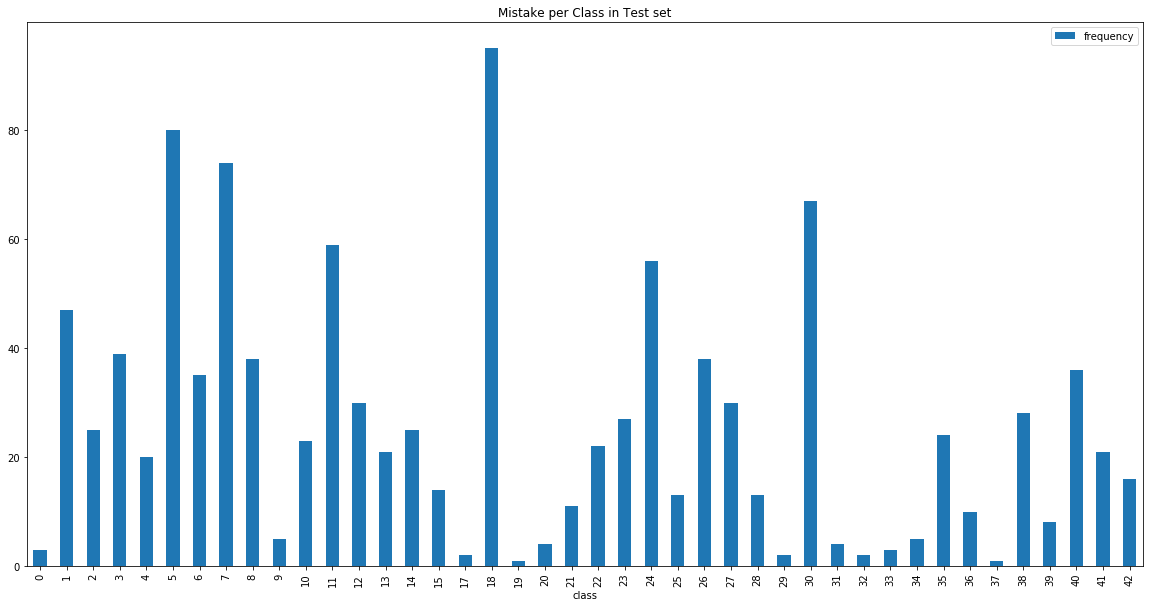

In [34]:
# We can also check how many mistakes our model make on each class
preds = tf.argmax(LeNet5(preprocess(X_test)), 1).numpy()
mistakes_mask = (preds != y_test)
mistakes = y_test[mistakes_mask]
classes_idx, frequency = np.unique(mistakes, return_counts=True)
df = pd.DataFrame({'class':classes_idx, 'frequency':frequency}).set_index('class')
df.plot.bar(figsize=(20,10), title='Mistake per Class in Test set')
# Alternatively, we can also generate a confusion matrix

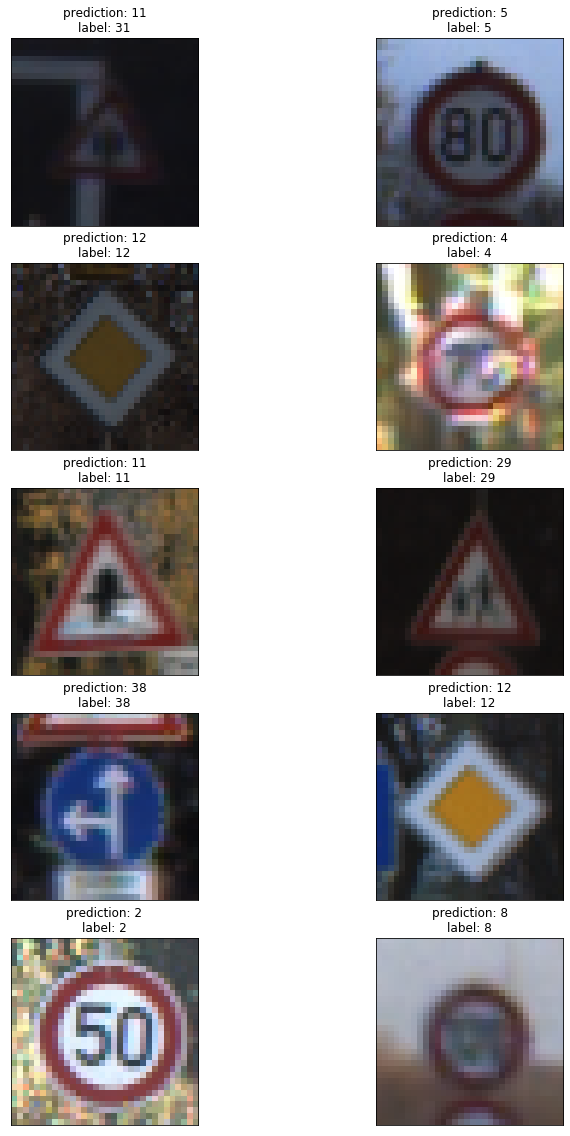

In [25]:
# Pick 10 random images from test set
indices = np.random.randint(len(X_test), size=10)
images = X_test[indices]
labels = y_test[indices]

# Pass through LeNet5
logits = LeNet5(preprocess(images))
predictions = tf.argmax(logits, 1).numpy()

# Show images with prediction & label
fig = plt.figure(figsize=(12, 20))
for idx in np.arange(10):
    ax = fig.add_subplot(5, 2, idx+1, xticks=[], yticks=[])
    ax.title.set_text(f'prediction: {classes[predictions[idx]]}\nlabel: {classes[labels[idx]]}')
    plt.imshow(images[idx])  

## Step 4: Test Model on New Images

In [49]:
# Find all downloaded images
import glob
from pathlib import Path

images_path = './download_images'
fnames = glob.glob(f'{images_path}/*.jpg')
fnames.sort()
print(*fnames, sep='\n') # print out a few filename examples

./download_images/test-01.jpg
./download_images/test-02.jpg
./download_images/test-03.jpg
./download_images/test-04.jpg
./download_images/test-05.jpg
./download_images/test-06.jpg
./download_images/test-07.jpg
./download_images/test-08.jpg


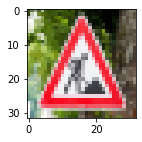

./download_images/test-01.jpg || Predict: 25 || Label: 25
____________________________________________________________________
rank  class                    name                          probs
 0  |  25  | Road work                                     | 1.00000
 1  |  20  | Dangerous curve to the right                  | 0.00000
 2  |  11  | Right-of-way at the next intersection         | 0.00000
 3  |   5  | Speed limit (80km/h)                          | 0.00000
 4  |   0  | Speed limit (20km/h)                          | 0.00000
____________________________________________________________________


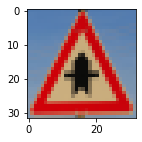

./download_images/test-02.jpg || Predict: 11 || Label: 11
____________________________________________________________________
rank  class                    name                          probs
 0  |  11  | Right-of-way at the next intersection         | 1.00000
 1  |  41  | End of no passing                             | 0.00000
 2  |   6  | End of speed limit (80km/h)                   | 0.00000
 3  |  42  | End of no passing by vehicles over 3.5 metric tons | 0.00000
 4  |   0  | Speed limit (20km/h)                          | 0.00000
____________________________________________________________________


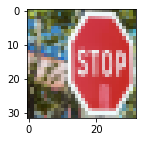

./download_images/test-03.jpg || Predict: 17 || Label: 14
____________________________________________________________________
rank  class                    name                          probs
 0  |  17  | No entry                                      | 0.58927
 1  |  14  | Stop                                          | 0.30453
 2  |  13  | Yield                                         | 0.06750
 3  |  12  | Priority road                                 | 0.03529
 4  |  33  | Turn right ahead                              | 0.00235
____________________________________________________________________


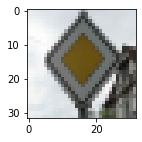

./download_images/test-04.jpg || Predict: 12 || Label: 12
____________________________________________________________________
rank  class                    name                          probs
 0  |  12  | Priority road                                 | 0.98464
 1  |  38  | Keep right                                    | 0.01536
 2  |   2  | Speed limit (50km/h)                          | 0.00001
 3  |   4  | Speed limit (70km/h)                          | 0.00000
 4  |  14  | Stop                                          | 0.00000
____________________________________________________________________


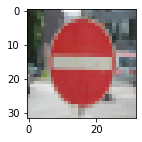

./download_images/test-05.jpg || Predict: 17 || Label: 17
____________________________________________________________________
rank  class                    name                          probs
 0  |  17  | No entry                                      | 1.00000
 1  |  37  | Go straight or left                           | 0.00000
 2  |  14  | Stop                                          | 0.00000
 3  |  33  | Turn right ahead                              | 0.00000
 4  |  40  | Roundabout mandatory                          | 0.00000
____________________________________________________________________


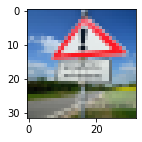

./download_images/test-06.jpg || Predict: 17 || Label: 18
____________________________________________________________________
rank  class                    name                          probs
 0  |  17  | No entry                                      | 1.00000
 1  |  38  | Keep right                                    | 0.00000
 2  |  14  | Stop                                          | 0.00000
 3  |  28  | Children crossing                             | 0.00000
 4  |   1  | Speed limit (30km/h)                          | 0.00000
____________________________________________________________________


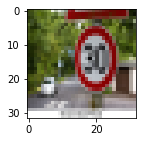

./download_images/test-07.jpg || Predict: 25 || Label: 1
____________________________________________________________________
rank  class                    name                          probs
 0  |  25  | Road work                                     | 1.00000
 1  |  20  | Dangerous curve to the right                  | 0.00000
 2  |   3  | Speed limit (60km/h)                          | 0.00000
 3  |   5  | Speed limit (80km/h)                          | 0.00000
 4  |  38  | Keep right                                    | 0.00000
____________________________________________________________________


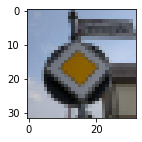

./download_images/test-08.jpg || Predict: 12 || Label: 12
____________________________________________________________________
rank  class                    name                          probs
 0  |  12  | Priority road                                 | 1.00000
 1  |   9  | No passing                                    | 0.00000
 2  |   2  | Speed limit (50km/h)                          | 0.00000
 3  |  25  | Road work                                     | 0.00000
 4  |  36  | Go straight or right                          | 0.00000
____________________________________________________________________

Accuracy: 0.625


In [50]:
import cv2

# Hard-coded labels for downloaded images
labels = np.array([25, 11, 14, 12, 17, 18, 1, 12])
preds = []

# Make prediction for downloaded images
for idx, image_name in  enumerate(fnames, start=0):
    raw_bgr = cv2.imread(image_name)
    img = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)   
    plt.figure(figsize=(2, 2))
    plt.imshow(resized_img)
    plt.show()
    # Pass through LeNet5
    logits = LeNet5(preprocess(resized_img[np.newaxis,:]))    
    probs, indices = tf.nn.top_k(tf.nn.softmax(logits), 5) # Find top 5 softmax probabilities
    probs, indices = probs[0].numpy(), indices[0].numpy()
    # Set class with highest probability as prediction for the current image
    preds.append(indices[0])
    print(f'{image_name} || Predict: {indices[0]} || Label: {labels[idx]}')
    print('____________________________________________________________________')
    # Show Top-5 probabilities
    print('rank  class                    name                          probs')
    print(*[f'{i:2}  | {indices[i]:3}  | {classes[indices[i]]:45} | {probs[i]:.5f}' for i in range(5)], sep='\n')
    print('____________________________________________________________________')

# Calculate accuracy
accuracy = np.sum(labels == preds) / len(labels)
print(f'\nAccuracy: {accuracy:.3f}')
